In [1]:
# This module is aimed at finding companies that are:
# 1). stable compared to ASX200 by either measure correlation to index or std deviation etc
# 2). the dividends issued over the last 12 months is consistent or better than history 
# 3). the dividends over the last 12 months divide by current share price is above the market median

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

In [ ]:
#Top 80% of asx200
# "CSL.AX CBA.AX BHP.AX WBC.AX NAB.AX WOW.AX ANZ.AX WES.AX TCL.AX MQG.AX FMG.AX TLS.AX RIO.AX GMG.AX NCM.AX WPL.AX COL.AX BXB.AX ALL.AX FPH.AX" 

In [150]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "^AXJO CSL.AX CBA.AX BHP.AX WBC.AX NAB.AX WOW.AX ANZ.AX WES.AX TCL.AX MQG.AX FMG.AX TLS.AX" ,

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "1y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        #interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column') or ticker
        group_by = 'column',

        # adjust all OHLC automatically
        # (optional, default is False)
        #auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        #prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  13 of 13 completed


In [151]:
#data.tail()

Adj Close                                                       \
              ANZ.AX     BHP.AX     CBA.AX      CSL.AX FMG.AX      MQG.AX   
Date                                                                        
2020-05-07     15.85  31.000000  59.259998  307.929993  11.45   99.550003   
2020-05-08     15.73  31.400000  59.599998  301.179993  12.04  105.190002   
2020-05-11     15.81  31.549999  60.139999  302.140015  12.11  111.540001   
2020-05-12     15.50  30.719999  59.709999  307.609985  11.72  107.010002   
2020-05-13     15.56  31.010000  60.849998  310.000000  12.18  106.389999   

                                            ...   Volume                     \
               NAB.AX TCL.AX TLS.AX WBC.AX  ...   CSL.AX    FMG.AX   MQG.AX   
Date                                        ...                               
2020-05-07  16.219999  13.42   3.06  15.60  ...  1208546   9815779   934125   
2020-05-08  16.080000  13.60   3.03  15.51  ...  1193753  11981676  2234281   
2020-05-11  15.980000  13.80   3.07  15.63  ...   619258   9794646  2261961   
2020-05-12  15.520000  13.65   3.09  15.23  ...   869289   9220721  1871019   
2020-05-13  15.640000  13.82   3.13  15.31  ...   743390  13483548  1992208   

                                                                             
              NAB.AX   TCL.AX    TLS.AX    WBC.AX   WES.AX   WOW.AX   ^AXJO  
Date                                                                         
2020-05-07  11916668  6767828  23516752   8369533  2418548  3188886  780000  
2020-05-08  12719481  5729473  22130682  10322277  2146783  2322743  851300  
2020-05-11  11836955  7429677  22071226   8158612  1643955  3425641  795500  
2020-05-12  14243074  5993226  23612862  10780859  1616964  3670175  866400  
2020-05-13  10801864  4817392  28555834   8102927  2028045  2177940       0  

[5 rows x 78 columns]

In [152]:
#Correlate open prices with all ords
import pandas as pd
from sklearn import preprocessing

data2 = data['Open']

x = data2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=df.columns)
df.columns = ["^AXJO", "CSL.AX", "CBA.AX", "BHP.AX", "WBC.AX", "NAB.AX", "WOW.AX", "ANZ.AX", "WES.AX", "TCL.AX", "MQG.AX", "FMG.AX", "TLS.AX"]
#df.set_index('Date')

#Correlate with the normalised data
correlation = df.corr(method='pearson').sort_values('^AXJO',ascending=False)
#correlation = data2.corr(method='pearson').sort_values('^AORD',ascending=False)

# order by highest correlation to aord
df_corr = correlation['^AXJO']

#data2.tail()

#df.head()
print(df_corr)


^AXJO     1.000000
TCL.AX    0.983412
WOW.AX    0.968159
CBA.AX    0.897706
TLS.AX    0.874997
CSL.AX    0.816445
WES.AX    0.815243
ANZ.AX    0.740234
NAB.AX    0.737404
MQG.AX    0.362169
FMG.AX   -0.024809
WBC.AX   -0.555362
BHP.AX   -0.622755
Name: ^AXJO, dtype: float64


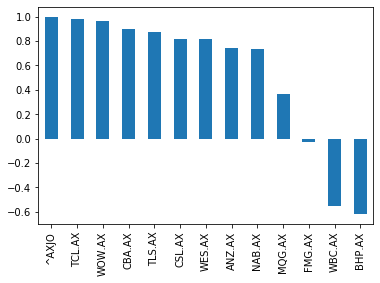

In [153]:
#Draw a scatter plot of these variables
df_corr.plot( kind="bar")



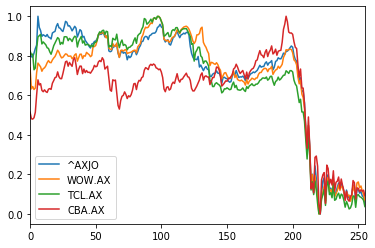

In [154]:
df.plot( y=["^AXJO", "WOW.AX", "TCL.AX", "CBA.AX"]
        , kind="line"
        , legend='out')


In [155]:
#Calculate dividend ratio

def Div_return(Tik_Name):
    Tik = yf.Ticker(Tik_Name)

    # minimum of last 4 dividends
    Div_Min_L4 = Tik.dividends.iloc[[-4,-3,-2,-1]].min()

    # get yesterdays closing price
    YTD_close = Tik.history(period="1d")["Close"]

    Div_Rate_1Y = (Div_Min_L4*2) / YTD_close
    return Div_Rate_1Y

x = Div_return("CBA.AX")
y = Div_return("WOW.AX")
z = Div_return("TCL.AX")

print(x,y,z)

Date
2020-05-13    0.065735
Name: Close, dtype: float64 Date
2020-05-13    0.025685
Name: Close, dtype: float64 Date
2020-05-13    0.040521
Name: Close, dtype: float64


In [ ]:
#Next phase
# Download all tickets within 1 index
# create automated threshold cutoff for stocks correlation with index
# create a list of outputs used in calculating the dividend return
# stress the stocks selected over various time periods